# Comprendre le mécanisme d'attention avec BERT
Lien : [Source code](https://towardsdatascience.com/deep-dive-into-the-code-of-bert-model-9f618472353e)

L'idée est ici de retracer pas à pas ce qui se passe dans le transformer-encoder de BERT. Dans un premier temps nous nous intéresserons à l'input : l'embedding des tokens. Puis au réseau de neurone (mécanisme de self-attention + Feed Forward).

Le mécanisme d'attention vise à pondérer les embeddings de chaque token en fonction de l'attention qu'ils portent aux autres. En portant son attention sur un token en particulier, il influence les embeddings.

Plan :     
1. Import du modèle & data + structure du modèle
2. Embedding initiaux en détail
3. L'encodeur & l'aglorithme

# 1. Import

In [ ]:
!pip install transformers bertviz

Téléchargement du modèle BERT.

In [ ]:
from bertviz.transformers_neuron_view import BertModel, BertConfig
from transformers import BertTokenizer
import torch
import math

# max_position_embeddings (int, optional, defaults to 512)
# The maximum sequence length that this model might ever be used with. Typically set this to something large just in case (e.g., 512 or 1024 or 2048).
max_length = 256
config = BertConfig.from_pretrained("bert-base-cased", output_attentions=True, output_hidden_states=True, return_dict=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
config.max_position_embeddings = max_length

100%|██████████| 433/433 [00:00<00:00, 2154369.67B/s]


Architecture du modèle : réseau de neurones. Explicitons le modèle :


1 : étape les (embeddings)

* (word_embeddings): Taille du vocabulaire : 28996. Longueur des vecteurs embeddings pour chaque token : 768   
* (position_embeddings): La taille maximale de l'input est une séquence de 256 tokens
* (token_type_embeddings): Différencier 2 phrases
* (LayerNorm): Couche de normalisation
* (dropout): Evite l'overfitting


2 : étape l'(encoder): 12 couches de self (attention)
* (query): la requête (l'input)
* (key): la cléf
* (value): la valeur à modeler
* (dropout): Evite l'overfitting
* (LayerNorm): Normalisation()


3 : (pooler): fonction d'(activation): Tanh()



In [ ]:
model = BertModel(config)
model = model.eval()

display(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(256, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (den

# 2. BertEmbeddings
On séléctionne 3 phrases du corpus. On les tokenize.

In [ ]:
# import du corpus de texte
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

# création des inputs : 3 phrases tokenisés
inputs_tests = tokenizer(newsgroups_train['data'][:3], truncation=True, padding=True, max_length=max_length, return_tensors='pt')
inputs = tokenizer(newsgroups_train['data'][3:6], truncation=True, padding=True, max_length=max_length, return_tensors='pt')

`inputs` est un dictionnaire contenant 3 vecteurs de dimension égale à celle de la taille d'entrée (256)
1. Dans `inputs['input_ids']` : les id des tokens du paragraphe (le vocabulaire est numéroté).
2. Dans `inputs['token_type_ids']` : 0 ou 1 s'il y a un token ou non (espace vide)
3. Dans `inputs['attention_mask']` : le masque d'attention, initialemement à 1

In [ ]:
inputs['token_type_ids'].shape

torch.Size([3, 256])

## word_embeddings

Taille du vocabulaire de BERT (30k) et la dimension de l'embedding (768).


In [ ]:
model.embeddings.word_embeddings.weight.shape

torch.Size([28996, 768])

## position_embeddings

Contrairement aux LSTM qui prennent en compte l'ordre des mots (prise en compte des mots les uns après les autres), BERT parallélise leur entrée (ce qui permet d'être plus rapide).

Il faut donc ajouter de cette information (ordre). Grace à la matrice position_embeddings de dimension :
* 256 : the max sentence length whilst (maximum sequence length that this model might ever be used with)
* 768 : the features dimension as for word embeddings

In [ ]:

model.embeddings.position_embeddings.weight.shape

torch.Size([256, 768])

Calcul des termes de la matrice.
$\mathrm{PE}_{i,j}=\sin \left( \frac{i}{1000^{2E(j/2)/d_m}}+ \frac{\pi}{2} j\right)$




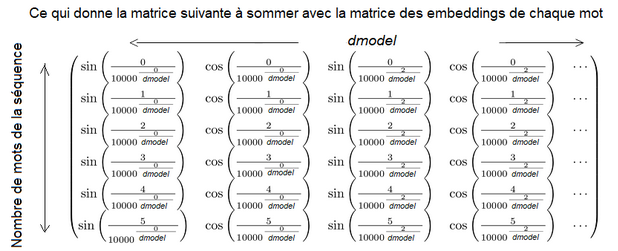

In [ ]:
model.embeddings.position_embeddings.weight

Parameter containing:
tensor([[-0.0058,  0.0002,  0.0125,  ..., -0.0110, -0.0080, -0.0016],
        [-0.0348,  0.0099,  0.0507,  ..., -0.0021,  0.0295, -0.0151],
        [-0.0223, -0.0019,  0.0356,  ...,  0.0052, -0.0167,  0.0017],
        ...,
        [-0.0189, -0.0190, -0.0081,  ...,  0.0267, -0.0427, -0.0077],
        [ 0.0053,  0.0222, -0.0135,  ...,  0.0068, -0.0016,  0.0069],
        [-0.0131, -0.0152, -0.0075,  ..., -0.0267, -0.0084,  0.0032]],
       requires_grad=True)

## token_type_embeddings
Séparer les différentes phrases (A ou B).

In [ ]:
# this embedding is needed to distinguish between the first and the second sentence. We do not need it as we have only one input sentence for classification task.
# token_type_embeddings is “redundant” here and comes from the Bert training task where the semantic similarity between two sentences is assessed
model.embeddings.token_type_embeddings.weight.shape

torch.Size([2, 768])

## Sommation des 3 embeddings pour former l'input du réseau de neurones

In [ ]:
# mini-batch de 3 phrases, 12 couches d'attention pour 12 têtes d'attention
n_batch = 3
tot_n_layers = 12
tot_n_heads = 12

# Dimension embedding : (3 phrases, 256 longueur max, 768 word embedding)
shape_embs = (inputs_tests['input_ids'].shape) + (model.embeddings.word_embeddings.weight.shape[1], )

# word_embeddings, position_embeddings & token_type_embeddings pour notre corpus
# index_select (input tensor to select elements, dim along which you want to select, indices elements selected)
w_embs_batch = torch.index_select(input=model.embeddings.word_embeddings.weight, dim=0, index=inputs_tests['input_ids'].reshape(1,-1).squeeze(0)).reshape(shape_embs)
pos_embs_batch = torch.index_select(model.embeddings.position_embeddings.weight, 0,
                                    torch.tensor(range(inputs_tests['input_ids'][1].size(0))).repeat(1, n_batch).squeeze(0)).reshape(shape_embs)
type_embs_batch = torch.index_select(model.embeddings.token_type_embeddings.weight, 0,
                                     inputs_tests['token_type_ids'].reshape(1,-1).squeeze(0)).reshape(shape_embs)

# On somme les 3 embeddings pour en avoir qu'un seul
batch_all_embs = w_embs_batch + pos_embs_batch + type_embs_batch
print(f'(batch_size, n_words, embedding dim) = {tuple(batch_all_embs.shape)}')

(batch_size, n_words, embedding dim) = (3, 256, 768)


In [ ]:
type_embs_batch[0][0][:5]

tensor([-0.0005, -0.0292, -0.0218, -0.0020,  0.0132], grad_fn=<SliceBackward0>)

## Fonction de normalisation

$$X^* = \frac{X-\mu}{\sigma} \sim \mathcal{N}(0,1) \quad \quad \mathrm{shifted\_x} = X^*W+b$$

$$\mathbb E [\mathrm{shifted\_x}] = \mathbb E[b] $$

$$\mathbb V [\mathrm{shifted\_x}] = \mathbb V[W] $$

In [ ]:
# Fonction de normalisation
# LayerNorm step helps the model to train faster and generalize better.
def layer_norm(x, w, b):
  """ x : matrice full sentence embeddin à normaliser à laquelle on applique une transformation affine
      w : poids du modèle
      b : biais
  """
  mean_x = x.mean(-1, keepdim=True) # moyenne sur la dernière dimension
  std_x = (x - mean_x).pow(2).mean(-1, keepdim=True)
  x_std = (x - mean_x) / torch.sqrt(std_x + 1e-12) # pas de division par 0
  shifted_x = w * x_std + b
  return shifted_x

# batch normalisation
# model.embeddings.LayerNorm : layer normalization operation applied to the input embeddings within the model architecture.
# We then apply a trained weight and bias vectors so it can be shifted to have a different mean and variance so the model during training can adapt automatically.
# Because we compute mean and standard deviation across different examples independently from the others,
# it is different from Batch normalization where the normalization is across the batch dimension and thus depends on other examples in the batch.
norm_embs = layer_norm(batch_all_embs, model.embeddings.LayerNorm.weight, model.embeddings.LayerNorm.bias)

In [ ]:
# apply Dropout : replace with zero some values
# Dropout helps to reduce overfitting as we randomly block signals from certain neurons
# the network needs to find other paths to reduce the loss function, and thus it learns how to generalise better instead of relying on certain paths.
## NB: because we set model to evaluation mode we will ignore all the dropout layers, they are only used during training. We still include it for completeness.

norm_embs_dropout = model.embeddings.dropout(norm_embs)

In [ ]:
# On obtient bien les mêmes résultats que le modèle
embs_model = model.embeddings(inputs_tests['input_ids'], inputs_tests['token_type_ids'])
torch.allclose(embs_model, norm_embs, atol=1e-06)

True

# Encodeur
Les matrices $W$ sont les matrices contenants les paramètres du modèle. Supposons pour simplifier $Q=K=V$, la matrice contenant les embeddings des tokens sur chaque ligne. En calculant $QK^T$, on accède à la matrice contenant les produits scalaires entre les embeddings de tous les tokens entre eux. En appliquant la fonction $\mathrm{softmax}$, on normalise ces produits scalaires là pour obtenir une matrice de transition (les sommes des coefficients sur chaque ligne sont égaux à 1). Enfin, en multipliant par $V$, on a modifier la matrice $V$, en pondérant par les similarités entre les tokens.

Dans cet exemple, on a considéré que les matrices contenants les embeddings en entier. En réalité, il y a 12 têtes d'attentions. On scinde donc les embeddings : $768/12=64$.





This is where attention is used to create different representations of the original embeddings that are context-dependent.

In the BertLayer we first try to understand BertAttention — after deriving the embeddings of each word.

Bert uses 3 matrices — Key, Query and Value, to compute attention scores and derive the new values for words embedding based on other words in the sentences; this way Bert is context aware, embedding of each word instead of being fixed and context independent is derived based on other words in the sentence and the importance of other words when deriving new embedding for a certain word is represented by the attention score.

To derive the query and key vector for each word we need to multiply its embedding by a trained matrix (which are separate for Queries and Keys).

$$K, Q, V \in \mathbb R^{(3 \times )256 \times 768}$$

$$\mathrm{Attention}(Q, K, V) = \mathrm{softmax} \left(\frac{1}{\sqrt{d_k}} Q K^T \right)V $$


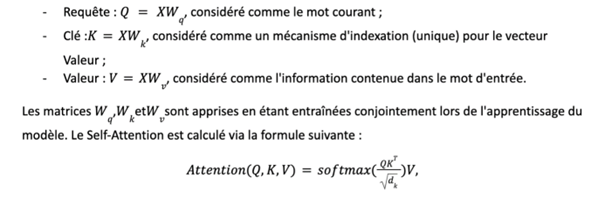


Ce qui est important de comprendre ici : le vecteur $X$ est identique pour la création de $Q, K, V$. En effet, on compare les tokens entre eux même : l'attention porte sur les éléments de l'input. C'est pour cela qu'il s'agit de **self-attention**. Les matrices $W_q, W_k, W_v$ sont les matrices des poids qui seront apris et mis à jour lors de l'entraînement.

In [ ]:
# Il y a n_att_heads=12 BertLayers et l'output de l'un est l'input du prochain
att_head_size = int(model.config.hidden_size/model.config.num_attention_heads)
n_att_heads = model.config.num_attention_heads

## Exemple sur la première tête
# Calcul de Q pour le premier mot
norm_embs[0][0, :] @ model.encoder.layer[0].attention.self.query.weight.T[:, :att_head_size] + \
                     model.encoder.layer[0].attention.self.query.bias[:att_head_size]

tensor([ 0.3437,  0.0469, -0.1836, -0.2779,  0.7825, -0.3185,  0.1913,  0.0538,
        -0.1921, -0.2774,  0.8730,  0.1324,  0.1510,  0.0315, -0.4081,  0.7408,
         0.7187, -0.5432, -0.3178, -0.0402, -0.7240, -0.8604, -0.8630, -0.2962,
        -0.0765,  0.6795,  0.1716, -0.0609, -0.0046, -0.7299, -0.2069, -0.0227,
         0.0447, -0.2107,  0.0389,  0.4784, -0.4674, -1.1412, -0.2008,  0.0071,
         0.6784, -0.1350,  0.1174, -0.3243, -0.0288,  0.3954, -0.0248,  0.7083,
        -1.2520,  1.3240,  0.9077, -1.0966, -0.8784,  0.4890, -0.7702,  0.0592,
        -0.1354, -0.4261, -0.2907, -0.5292,  0.4916, -0.0369, -0.3990,  0.0788],
       grad_fn=<AddBackward0>)

In [ ]:
tot_n_heads, tot_n_layers

(12, 12)

In [ ]:
normalized_embs = layer_norm(batch_all_embs, model.embeddings.LayerNorm.weight, model.embeddings.LayerNorm.bias)

# Tensor de 1=there is a token in that positio et 0=padded token
extended_attention_mask = inputs['attention_mask'].unsqueeze(1).unsqueeze(2)
# Rempli de 0 car que des tokens, pas de padding
# when we apply SoftMax we effectively send to zero those negative values and then derive probabilities based on other values.
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

# On itère sur les 12 couches d'attentions
for layer_n in range(tot_n_layers):
# Pour la première couche : initiation
 if layer_n == 0:
   # compute Query, Key and Value matrices
   Q = normalized_embs @ model.encoder.layer[layer_n].attention.self.query.weight.T + model.encoder.layer[layer_n].attention.self.query.bias
   K = normalized_embs @ model.encoder.layer[layer_n].attention.self.key.weight.T + model.encoder.layer[layer_n].attention.self.key.bias
   V = normalized_embs @ model.encoder.layer[layer_n].attention.self.value.weight.T + model.encoder.layer[layer_n].attention.self.value.bias
   # reshape : new_x_shape=(3 phrases, 256 longueur max, 12 attention heads, 64 att_head_size)
   ## Each of these attention heads creates different representation of words (new_embed_1 matrix) 64*12=768 word embedding
   new_x_shape = Q.size()[:-1] + (n_att_heads, att_head_size)
   Q_reshaped = Q.view(*new_x_shape)
   K_reshaped = K.view(*new_x_shape)
   V_reshaped = V.view(*new_x_shape)
   # compute attention probabilities
   # softmax(QKt/d**.5) obtention de proba. Somme=1. Parmutation des dimensions (3 phrases, 12 attention heads, 256 longueur max, 64 att_head_size)
   att_scores = (Q_reshaped.permute(0, 2, 1, 3) @ K_reshaped.permute(0, 2, 1, 3).transpose(-1, -2))
   att_scores = (att_scores/ math.sqrt(att_head_size)) + extended_attention_mask
   attention_probs = torch.nn.Softmax(dim=-1)(att_scores)
   # concatenate attention heads : the results from the 12 heads and pass them through a bunch of linear layers,
   att_heads = []
   for i in range(tot_n_heads):
   # Attention = softmax * V
   # We then multiply these Values by the attention scores to get the new context-aware words representations
    att_heads.append(attention_probs[:, i] @ V_reshaped[:, : , i, :])
   # fin boucle for

   # passing our concatenated attention results through a linear layer
   output_dense = torch.cat(att_heads, 2) @ model.encoder.layer[layer_n].attention.output.dense.weight.T + \
                                            model.encoder.layer[layer_n].attention.output.dense.bias
   # normalization + residual connection
   output_layernorm = layer_norm(output_dense + normalized_embs,
                                 model.encoder.layer[layer_n].attention.output.LayerNorm.weight,
                                 model.encoder.layer[layer_n].attention.output.LayerNorm.bias)
   # linear layer + non linear gelu activation GELU(x)=xP[X<=x]
   # GeLU is non-monotonic, non-convex and non-linear in the positive domain and thus can approximate more easily complicated functions.
   interm_dense = torch.nn.functional.gelu(output_layernorm @ model.encoder.layer[layer_n].intermediate.dense.weight.T + \
                                           model.encoder.layer[layer_n].intermediate.dense.bias)
   # linear layer
   out_dense = interm_dense @ model.encoder.layer[layer_n].output.dense.weight.T + model.encoder.layer[layer_n].output.dense.bias
   # normalization + residual connection
   # out_layernorm : sortie de la première head attention
   out_layernorm = layer_norm(out_dense + output_layernorm,
                              model.encoder.layer[layer_n].output.LayerNorm.weight,
                              model.encoder.layer[layer_n].output.LayerNorm.bias)

# Pour les couches suivantes : utilisation de l'output précédent : out_layernorm
 else:
   # compute Q, K and V matrices, avec le dernier out_layernorm
   Q = out_layernorm @ model.encoder.layer[layer_n].attention.self.query.weight.T + \
                              model.encoder.layer[layer_n].attention.self.query.bias
   K = out_layernorm @ model.encoder.layer[layer_n].attention.self.key.weight.T + \
                              model.encoder.layer[layer_n].attention.self.key.bias
   V = out_layernorm @ model.encoder.layer[layer_n].attention.self.value.weight.T + \
                              model.encoder.layer[layer_n].attention.self.value.bias
   # reshape : new_x_shape=(3 phrases, 256 longueur max, 12 attention heads, 64 att_head_size)
   Q_reshaped = Q.view(*new_x_shape)
   K_reshaped = K.view(*new_x_shape)
   V_reshaped = V.view(*new_x_shape)
   # compute attention probabilities
   # softmax(QKt/d**.5) obtention de proba. Somme=1. Parmutation des dimensions (3 phrases, 12 attention heads, 256 longueur max, 64 att_head_size)
   att_scores = (Q_reshaped.permute(0, 2, 1, 3) @ K_reshaped.permute(0, 2, 1, 3).transpose(-1, -2))
   att_scores = (att_scores/ math.sqrt(att_head_size)) + extended_attention_mask
   attention_probs = torch.nn.Softmax(dim=-1)(att_scores)
   # concatenate attention heads : the results from the 12 heads and pass them through a bunch of linear layers,
   att_heads = []
   for i in range(tot_n_heads):
   # Attention = softmax * V
   # We then multiply these Values by the attention scores to get the new context-aware words representations
    att_heads.append(attention_probs[:, i] @ V_reshaped[:, : , i, :])
   # fin boucle for

   # passing our concatenated attention results through a linear layer
   output_dense = torch.cat(att_heads, 2) @ model.encoder.layer[layer_n].attention.output.dense.weight.T + \
                                            model.encoder.layer[layer_n].attention.output.dense.bias
   # normalization + residual connection
   output_layernorm = layer_norm(output_dense + out_layernorm,
                                 model.encoder.layer[layer_n].attention.output.LayerNorm.weight,
                                 model.encoder.layer[layer_n].attention.output.LayerNorm.bias)

   # linear layer + non linear gelu activation
   interm_dense = torch.nn.functional.gelu(output_layernorm @ model.encoder.layer[layer_n].intermediate.dense.weight.T + \
                                                              model.encoder.layer[layer_n].intermediate.dense.bias)
   # linear layer
   out_dense = interm_dense @ model.encoder.layer[layer_n].output.dense.weight.T + model.encoder.layer[layer_n].output.dense.bias
   # normalization + residual connection
   out_layernorm = layer_norm(out_dense + output_layernorm,
                              model.encoder.layer[layer_n].output.LayerNorm.weight,
                              model.encoder.layer[layer_n].output.LayerNorm.bias)

In [ ]:
out_layernorm.shape

torch.Size([3, 256, 768])

In [ ]:
Q_first_head = norm_embs[0] @ model.encoder.layer[0].attention.self.query.weight.T[:, :att_head_size] + \
               model.encoder.layer[0].attention.self.query.bias[:att_head_size]
K_first_head = norm_embs[0] @ model.encoder.layer[0].attention.self.key.weight.T[:, :att_head_size] + \
               model.encoder.layer[0].attention.self.key.bias[:att_head_size]
torch.nn.functional.softmax(torch.tensor([0,0,0, -10000, -10000]).float())
# tensor([0.3333, 0.3333, 0.3333, 0.0000, 0.0000])
mod_attention = (1.0 - inputs['attention_mask'][[0]]) * -10000.0
attention_scores = torch.nn.Softmax(dim=-1)((Q_first_head @ K_first_head.T)/ math.sqrt(att_head_size) + mod_attention)

<ipython-input-36-885c19d96949>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(torch.tensor([0,0,0, -10000, -10000]).float())


In [ ]:
out_view = model(**inputs_tests)
torch.allclose(attention_scores, out_view[-1][0]['attn'][0, 0, :, :], atol=1e-06)

False

Sortie du modèle :

*	last_hidden_state (batch_size, sequence_length, hidden_size) : last hidden state which is outputted from the last BertLayer
*	pooler_output (batch_size, hidden_size) : output of the Pooler layer
*	hidden_states (batch_size, sequence_length, hidden_size): hidden-states of the model at the output of each BertLayer plus the initial embedding
*	attentions (batch_size, num_heads, sequence_length, sequence_length): one for each BertLayer. Attentions weights after the attention SoftMax

In [ ]:
Q.shape, Q_reshaped.shape

In [ ]:
output_dense.shape